# for Statistical Significance

Prepping of Assessment Scores, Clicks, aggregated and cumulated

##### Import Libraries

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

import os
import math

import scipy
import scipy.stats as stats

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip

import patsy
from patsy import dmatrices

print (pd.__version__)
print (np.__version__)
print (matplotlib.__version__)
print (sns.__version__)
print (os.name)
print(hasattr(math, "isfinite"))

print (scipy.__version__)
print (statsmodels.__version__)
print (patsy.__version__)

1.2.4
1.20.1
3.3.4
0.11.1
nt
True
1.6.2
0.12.2
0.5.1


In [2]:
os.getcwd()
os.chdir('C:\\Users\\EeLian\\Desktop\\OULAD_KAGGLE\\PythonCodeCleanUp\\Data')

### ASSESSMENT SCORES

##### What we want to prepare

##### Aggregated Dimension set 1
* id_student
* code_module
* code_presentation
* final_result
* date_group

##### Aggregated Dimension set 2
* code_module
* code_presentation
* final_result
* date_group

##### _surrogate_key_one
* id_student
* code_module
* code_presentation

##### _surrogate_key_two
* final_result
* code_module
* code_presentation

##### Aggregated Metrics
* week_agg_cum_weighted_score
* week_agg_weighted_score
* week_agg_cum_sum_click
* week_agg_sum_click

##### studentInfo + courses + studentRegistration

In [3]:
# import tables
studentInfo = pd.read_csv('studentInfo.csv')
courses = pd.read_csv('courses.csv')
studentRegistration = pd.read_csv('studentRegistration.csv')
# Find latest Module
studentInfo.sort_values(by= ['id_student','code_module','code_presentation'], inplace = True, ascending = False)
studentInfo['_fl_latest_module_attended'] = studentInfo.groupby(['id_student','code_module'])['id_student'].rank(method='first', ascending = False)
# Merge Info with Courses and Registration
studentInfo2 = studentInfo.merge(courses, how='left', left_on=["code_module", "code_presentation"], right_on=["code_module", "code_presentation"])
studentInfo3 = studentInfo2.merge(studentRegistration, how='left', left_on=["code_module", "code_presentation","id_student"], right_on=["code_module", "code_presentation","id_student"])

### studentAssessment + assessments

In [4]:
# Import Table
studentAssessment = pd.read_csv('studentAssessment.csv')
assessments = pd.read_csv('assessments.csv')
# Merge Student Assessment with Assessment
studentAssessment2 = studentAssessment.merge(assessments, how='left', left_on=["id_assessment"], right_on=["id_assessment"])
# Flag null scores
studentAssessment2['_flag_null_score']=studentAssessment2['score'].isnull().astype(int)
# compute partial weighted score. Partial cos without denominator yet
studentAssessment2['_weighted_score'] = studentAssessment2['score']*studentAssessment2['weight']
# flag pass fail for each assessment score using 40 percent mark
studentAssessment2.loc[studentAssessment2['score'] >=40, '_flag_assessment_passed'] = 1
studentAssessment2.loc[studentAssessment2['score'] <40, '_flag_assessment_passed'] = 0
# add date groups in weeks
studentAssessment2["_date_group"] = pd.Series([], dtype=float)
studentAssessment2["_date_group"] = studentAssessment2['date_submitted']
studentAssessment2.loc[studentAssessment2['date_submitted'] <0, '_date_group'] = studentAssessment2['_date_group'].apply(lambda x: math.ceil(float(x/7)))
studentAssessment2.loc[studentAssessment2['date_submitted'] >=0, '_date_group'] = studentAssessment2['_date_group'].apply(lambda x: math.floor(float((x/7)+1)))

In [5]:
# Distinct list of students
studentInfo3_results_distinct=studentInfo3[['id_student','code_module','code_presentation','final_result']]
studentInfo3_results_distinct=studentInfo3_results_distinct.drop_duplicates()

# Merge Left: Student Assessments, Right: studentInfo
studentAssessment3 = studentAssessment2.merge(studentInfo3_results_distinct, how='left', \
                                                 left_on=["id_student","code_module", "code_presentation"], \
                                                 right_on=["id_student","code_module", "code_presentation"])

# create Surrogate Keys
studentAssessment3['_surrogate_key_one']=\
    studentAssessment3['id_student'].astype(str) + \
    studentAssessment3['final_result']+ \
    studentAssessment3['code_module']+ \
    studentAssessment3['code_presentation']
studentAssessment3['_surrogate_key_two']=\
    studentAssessment3['final_result']+ \
    studentAssessment3['code_module']+ \
    studentAssessment3['code_presentation']

In [6]:
# sum score at student and _date_group level
tbl_week_aggstd_weighted_score=studentAssessment3[['_surrogate_key_one','_date_group','_weighted_score']]

tbl_week_aggstd_one_cum_weighted_score=\
    tbl_week_aggstd_weighted_score.sort_values(by = ['_surrogate_key_one','_date_group','_weighted_score'], \
                                               ascending = True, na_position = 'first')

tbl_week_aggstd_one_cum_weighted_score=\
    tbl_week_aggstd_one_cum_weighted_score.groupby(['_surrogate_key_one','_date_group']).sum() \
      .groupby(level=0).cumsum().reset_index()

tbl_week_aggstd_one_cum_weighted_score.columns = ['_surrogate_key_one','_date_group','week_agg_cum_weighted_score']

#########################################################

# sums up the scores for each _date_gorup for student
tbl_week_aggstd_one_weighted_score=tbl_week_aggstd_weighted_score.\
            set_index(['_surrogate_key_one','_date_group']).\
            groupby(['_surrogate_key_one','_date_group']).\
            agg({'_weighted_score':['sum']})
tbl_week_aggstd_one_weighted_score.columns = ['week_agg_weighted_score']
tbl_week_aggstd_one_weighted_score = tbl_week_aggstd_one_weighted_score.reset_index()

In [7]:
# sums up scores at results, _date_group level
tbl_week_aggnostd2_two_weighted_score=studentAssessment3[['_surrogate_key_two','_date_group','_weighted_score']]

tbl_week_aggnostd_two_weighted_score=tbl_week_aggnostd2_two_weighted_score.\
            set_index(['_surrogate_key_two','_date_group']).\
            groupby(['_surrogate_key_two','_date_group']).\
            agg({'_weighted_score':['sum']})
tbl_week_aggnostd_two_weighted_score.columns = ['week_agg_weighted_score']
tbl_week_aggnostd_two_weighted_score = tbl_week_aggnostd_two_weighted_score.reset_index()

######################################
# cumulative sum at results, _date_group level
tbl_week_aggnostd_two_cum_weighted_score=\
    tbl_week_aggnostd_two_weighted_score.sort_values(by = ['_surrogate_key_two','_date_group','week_agg_weighted_score'], \
                                               ascending = True, na_position = 'first')

tbl_week_aggnostd_two_cum_weighted_score=\
    tbl_week_aggnostd_two_cum_weighted_score.groupby(['_surrogate_key_two','_date_group']).sum() \
      .groupby(level=0).cumsum().reset_index()

tbl_week_aggnostd_two_cum_weighted_score.columns = ['_surrogate_key_two','_date_group','week_agg_cum_weighted_score']

In [8]:
#tbl_week_aggstd_one_cum_weighted_score
#tbl_week_aggstd_one_weighted_score
#tbl_week_aggnostd_two_cum_weighted_score
#tbl_week_aggnostd_two_weighted_score
#tbl_week_aggstd_one_cum_weighted_score.to_csv('DatasetForTempStat_aggstd_cum_score.csv',index=True,header=True)
#tbl_week_aggstd_one_weighted_score.to_csv('DatasetForTempStat_aggstd_score.csv',index=True,header=True)
#tbl_week_aggnostd_two_cum_weighted_score.to_csv('DatasetForTempStat_aggnostd_cum_score.csv',index=True,header=True)
#tbl_week_aggnostd_two_weighted_score.to_csv('DatasetForTempStat_aggnostd_score.csv',index=True,header=True)

In [9]:
# denominator for final weighted scores
studentInfo3_results_distinct_dash=studentInfo3_results_distinct
studentInfo3_results_distinct_dash['_surrogate_key_one']=\
    studentInfo3_results_distinct_dash['id_student'].astype(str) + \
    studentInfo3_results_distinct_dash['final_result']+ \
    studentInfo3_results_distinct_dash['code_module']+ \
    studentInfo3_results_distinct_dash['code_presentation']

tbl_week_aggstd_one_cum_weighted_score_dash = tbl_week_aggstd_one_cum_weighted_score.merge(studentInfo3_results_distinct_dash, how='left', \
                                                 left_on=["_surrogate_key_one"], \
                                                 right_on=["_surrogate_key_one"])

tbl_week_aggstd_one_cum_weighted_score_dash.loc[tbl_week_aggstd_one_cum_weighted_score_dash['code_module'].isin(['AAA']), '_final_week_agg_cum_weighted_score'] = \
tbl_week_aggstd_one_cum_weighted_score_dash['week_agg_cum_weighted_score']/100

tbl_week_aggstd_one_cum_weighted_score_dash.loc[tbl_week_aggstd_one_cum_weighted_score_dash['code_module'].isin(['BBB']), '_final_week_agg_cum_weighted_score'] = \
tbl_week_aggstd_one_cum_weighted_score_dash['week_agg_cum_weighted_score']/100

tbl_week_aggstd_one_cum_weighted_score_dash.loc[tbl_week_aggstd_one_cum_weighted_score_dash['code_module'].isin(['CCC']), '_final_week_agg_cum_weighted_score'] = \
tbl_week_aggstd_one_cum_weighted_score_dash['week_agg_cum_weighted_score']/200

tbl_week_aggstd_one_cum_weighted_score_dash.loc[tbl_week_aggstd_one_cum_weighted_score_dash['code_module'].isin(['DDD']), '_final_week_agg_cum_weighted_score'] = \
tbl_week_aggstd_one_cum_weighted_score_dash['week_agg_cum_weighted_score']/200

tbl_week_aggstd_one_cum_weighted_score_dash.loc[tbl_week_aggstd_one_cum_weighted_score_dash['code_module'].isin(['EEE']), '_final_week_agg_cum_weighted_score'] = \
tbl_week_aggstd_one_cum_weighted_score_dash['week_agg_cum_weighted_score']/100

tbl_week_aggstd_one_cum_weighted_score_dash.loc[tbl_week_aggstd_one_cum_weighted_score_dash['code_module'].isin(['FFF']), '_final_week_agg_cum_weighted_score'] = \
tbl_week_aggstd_one_cum_weighted_score_dash['week_agg_cum_weighted_score']/100

tbl_week_aggstd_one_cum_weighted_score_dash.loc[tbl_week_aggstd_one_cum_weighted_score_dash['code_module'].isin(['GGG']), '_final_week_agg_cum_weighted_score'] = \
tbl_week_aggstd_one_cum_weighted_score_dash['week_agg_cum_weighted_score']/100



In [10]:
# dataset for full-fledged dashboard
tbl_week_aggstd_one_cum_weighted_score_dash.to_csv('Dataset_Dashboard_Table1_aggstd_score.csv',index=True,header=True)

In [11]:
#tbl_week_aggstd_one_cum_weighted_score.info()

### Arbitrary Keys

In [12]:
# arbitrary keys
# This is to plot the chart
# for sizing when plotting the chart. not all subjects have the same duration
print(tbl_week_aggstd_one_cum_weighted_score['_date_group'].min())
print(tbl_week_aggstd_one_cum_weighted_score['_date_group'].max())

-1
87


In [13]:
#import numpy as np
#from pandas import DataFrame
# create a list of _date_groups/ weeks for chart plotting purposes
_date_group_base=np.arange(-3, 90, 1).tolist()

tbl_date_group_base = DataFrame(_date_group_base,columns=['_date_group'])
tbl_date_group_base['joinkey']=1
#tbl_date_group_base.info()

studentAssessment3_aggnostd_two_distinct=studentAssessment3[['_surrogate_key_two','code_module','code_presentation','final_result']]
studentAssessment3_aggnostd_two_distinct=studentAssessment3_aggnostd_two_distinct.drop_duplicates()

studentAssessment3_aggnostd_two_distinct['joinkey']=1
studentAssessment3_aggnostd_two_distinct_alldategroup = \
pd.merge(studentAssessment3_aggnostd_two_distinct, tbl_date_group_base, on ='joinkey').drop('joinkey', 1)

#print(studentAssessment3_aggnostd_two_distinct_alldategroup.info())
#print(studentAssessment3_aggnostd_two_distinct.info())
#print(tbl_date_group_base.info())

In [14]:
tbl_week_aggnostd_two_score2 = studentAssessment3_aggnostd_two_distinct_alldategroup\
    .merge(tbl_week_aggnostd_two_cum_weighted_score, how='left', \
           left_on=['_surrogate_key_two', '_date_group'], \
           right_on=['_surrogate_key_two', '_date_group']) \
    .merge(tbl_week_aggnostd_two_weighted_score, how='left', \
         left_on=['_surrogate_key_two', '_date_group'], \
         right_on=['_surrogate_key_two', '_date_group'])

In [15]:
# fill up the NAs
# tbl_week_aggnostd_two_score['week_agg_weighted_score'].fillna(0)
tbl_week_aggnostd_two_score2['week_agg_weighted_score'] = tbl_week_aggnostd_two_score2['week_agg_weighted_score'].replace(np.nan, 0)
# tbl_week_aggnostd_two_score2

In [16]:
tbl_week_aggnostd_two_score3=tbl_week_aggnostd_two_score2[['_surrogate_key_two','_date_group','week_agg_weighted_score']]

tbl_week_aggnostd_two_score4=\
    tbl_week_aggnostd_two_score3.sort_values(by = ['_surrogate_key_two','_date_group','week_agg_weighted_score'], \
                                               ascending = True, na_position = 'first')

tbl_week_aggnostd_two_score4=\
    tbl_week_aggnostd_two_score4.groupby(['_surrogate_key_two','_date_group']).sum() \
      .groupby(level=0).cumsum().reset_index()

tbl_week_aggnostd_two_score4.columns = ['_surrogate_key_two','_date_group','week_agg_cum_weighted_score2']

In [17]:
tbl_week_aggnostd_two_score5 = tbl_week_aggnostd_two_score2\
    .merge(tbl_week_aggnostd_two_score4, how='left', \
           left_on=['_surrogate_key_two', '_date_group'], \
           right_on=['_surrogate_key_two', '_date_group'])

tbl_week_aggnostd_two_score5=tbl_week_aggnostd_two_score5.drop(['week_agg_cum_weighted_score'], axis = 1)
tbl_week_aggnostd_two_score5['week_agg_cum_weighted_score']=tbl_week_aggnostd_two_score5['week_agg_cum_weighted_score2']
tbl_week_aggnostd_two_score5=tbl_week_aggnostd_two_score5.drop(['week_agg_cum_weighted_score2'], axis = 1)
#tbl_week_aggnostd_two_score5.to_csv('DatasetForTempStat_aggnostd_score_finaltable.csv',index=True,header=True)

##### Count students

In [18]:
studentInfo3['_surrogate_key_one']=\
    studentInfo3['id_student'].astype(str) + \
    studentInfo3['final_result']+ \
    studentInfo3['code_module']+ \
    studentInfo3['code_presentation']
studentInfo3['_surrogate_key_two']=\
    studentInfo3['final_result']+ \
    studentInfo3['code_module']+ \
    studentInfo3['code_presentation']

In [19]:
tbl_studentInfo3_aggnostd_two_stdcount=studentInfo3.\
            set_index(['_surrogate_key_two']).\
            groupby(['_surrogate_key_two']).\
            agg({'id_student':['count']})

tbl_studentInfo3_aggnostd_two_stdcount.columns = ['agg_student_count']
tbl_studentInfo3_aggnostd_two_stdcount = tbl_studentInfo3_aggnostd_two_stdcount.reset_index()

In [20]:
tbl_week_aggnostd_two_score6 = tbl_week_aggnostd_two_score5\
    .merge(tbl_studentInfo3_aggnostd_two_stdcount, how='left', \
           left_on=['_surrogate_key_two'], \
           right_on=['_surrogate_key_two'])

In [21]:
tbl_week_aggnostd_two_score6['per_student_avg_week_agg_cum_weighted_score']=\
tbl_week_aggnostd_two_score6['week_agg_cum_weighted_score']/\
tbl_week_aggnostd_two_score6['agg_student_count']
#tbl_week_aggnostd_two_score6

##### Weighted Score Total Denominator Value
* AAA 100
* BBB 100
* CCC 200
* DDD 200
* EEE 100
* FFF 100
* GGG ZERO

In [22]:
# division with the denominator forming the final weighted score

tbl_week_aggnostd_two_score6.loc[tbl_week_aggnostd_two_score6['code_module'].isin(['AAA']), 'per_student_avg_week_agg_cum_weighted_score2'] = \
tbl_week_aggnostd_two_score6['week_agg_cum_weighted_score']/\
tbl_week_aggnostd_two_score6['agg_student_count']/100

tbl_week_aggnostd_two_score6.loc[tbl_week_aggnostd_two_score6['code_module'].isin(['BBB']), 'per_student_avg_week_agg_cum_weighted_score2'] = \
tbl_week_aggnostd_two_score6['week_agg_cum_weighted_score']/\
tbl_week_aggnostd_two_score6['agg_student_count']/100

tbl_week_aggnostd_two_score6.loc[tbl_week_aggnostd_two_score6['code_module'].isin(['CCC']), 'per_student_avg_week_agg_cum_weighted_score2'] = \
tbl_week_aggnostd_two_score6['week_agg_cum_weighted_score']/\
tbl_week_aggnostd_two_score6['agg_student_count']/200

tbl_week_aggnostd_two_score6.loc[tbl_week_aggnostd_two_score6['code_module'].isin(['DDD']), 'per_student_avg_week_agg_cum_weighted_score2'] = \
tbl_week_aggnostd_two_score6['week_agg_cum_weighted_score']/\
tbl_week_aggnostd_two_score6['agg_student_count']/200

tbl_week_aggnostd_two_score6.loc[tbl_week_aggnostd_two_score6['code_module'].isin(['EEE']), 'per_student_avg_week_agg_cum_weighted_score2'] = \
tbl_week_aggnostd_two_score6['week_agg_cum_weighted_score']/\
tbl_week_aggnostd_two_score6['agg_student_count']/100

tbl_week_aggnostd_two_score6.loc[tbl_week_aggnostd_two_score6['code_module'].isin(['FFF']), 'per_student_avg_week_agg_cum_weighted_score2'] = \
tbl_week_aggnostd_two_score6['week_agg_cum_weighted_score']/\
tbl_week_aggnostd_two_score6['agg_student_count']/100

tbl_week_aggnostd_two_score6.loc[tbl_week_aggnostd_two_score6['code_module'].isin(['GGG']), 'per_student_avg_week_agg_cum_weighted_score2'] = \
tbl_week_aggnostd_two_score6['week_agg_cum_weighted_score']/\
tbl_week_aggnostd_two_score6['agg_student_count']/100

In [23]:
tbl_week_aggnostd_two_score6=tbl_week_aggnostd_two_score6.drop(['per_student_avg_week_agg_cum_weighted_score'], axis = 1)
tbl_week_aggnostd_two_score6['per_student_avg_week_agg_cum_weighted_score']=tbl_week_aggnostd_two_score6['per_student_avg_week_agg_cum_weighted_score2']
tbl_week_aggnostd_two_score6=tbl_week_aggnostd_two_score6.drop(['per_student_avg_week_agg_cum_weighted_score2'], axis = 1)

# store as CSV for dashboard
# tbl_week_aggnostd_two_score6.to_csv('DatasetForStat_aggnostd_score_finaltable.csv',index=True,header=True)
tbl_week_aggnostd_two_score6.to_csv('Dataset_Dashboard_Table1_aggnostd_score.csv',index=True,header=True) #added

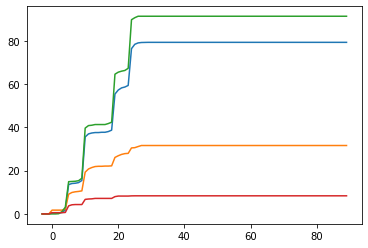

In [24]:
# import matplotlib.pyplot as plt
X_PassEEE2014J= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['PassEEE2014J']))]
X_FailEEE2014J= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['FailEEE2014J']))]
X_DistinctionEEE2014J= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['DistinctionEEE2014J']))]
X_WithdrawnEEE2014J= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['WithdrawnEEE2014J']))]

plt.plot(X_PassEEE2014J['_date_group'], X_PassEEE2014J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_FailEEE2014J['_date_group'], X_FailEEE2014J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_DistinctionEEE2014J['_date_group'], X_DistinctionEEE2014J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_WithdrawnEEE2014J['_date_group'], X_WithdrawnEEE2014J['per_student_avg_week_agg_cum_weighted_score'])
# plt.plot(_date_group, np.cos(x));

### XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
### CLICKS

##### Repeat the Same for Clicks

In [25]:
# import tables
studentVle = pd.read_csv('studentVle.csv')
studentVle2 = studentVle
vle = pd.read_csv('vle.csv')
# merge vle with studentVle
studentVle3 = studentVle2.merge(vle, how='left', \
                                                 left_on=["code_module", "code_presentation","id_site"], \
                                                 right_on=["code_module", "code_presentation","id_site"])
#studentVle3.to_csv('studentVle3.csv',index=True,header=True)

In [26]:
# add _date_groups/weeks
studentVle3['_date_group'] = pd.Series([], dtype=float)
studentVle3['_date_group'] = studentVle3['date']
studentVle3.loc[studentVle3['date'] <0, '_date_group'] = studentVle3['_date_group'].apply(lambda x: math.ceil(float(x/7)))
studentVle3.loc[studentVle3['date'] >=0, '_date_group'] = studentVle3['_date_group'].apply(lambda x: math.floor(float((x/7)+1)))

In [27]:
# for sizing when plotting the chart. not all subjects have the same duration
print(studentVle3['_date_group'].max())
print(studentVle3['_date_group'].min())

39
-3


In [28]:
studentInfo3_results_distinct=studentInfo3[['id_student','code_module','code_presentation','final_result']]
studentInfo3_results_distinct=studentInfo3_results_distinct.drop_duplicates()

studentVle4 = studentVle3.merge(studentInfo3_results_distinct, how='left', \
                                                 left_on=["id_student","code_module", "code_presentation"], \
                                                 right_on=["id_student","code_module", "code_presentation"])

studentVle4['_surrogate_key_one']=\
    studentVle4['id_student'].astype(str) + \
    studentVle4['final_result']+ \
    studentVle4['code_module']+ \
    studentVle4['code_presentation']
studentVle4['_surrogate_key_two']=\
    studentVle4['final_result']+ \
    studentVle4['code_module']+ \
    studentVle4['code_presentation']

In [29]:
tbl_week_aggstd_sum_click=studentVle4[['_surrogate_key_one','_date_group','sum_click']]

tbl_week_aggstd_one_cum_sum_click=\
    tbl_week_aggstd_sum_click.sort_values(by = ['_surrogate_key_one','_date_group','sum_click'], \
                                               ascending = True, na_position = 'first')

tbl_week_aggstd_one_cum_sum_click=\
    tbl_week_aggstd_one_cum_sum_click.groupby(['_surrogate_key_one','_date_group']).sum() \
      .groupby(level=0).cumsum().reset_index()

tbl_week_aggstd_one_cum_sum_click.columns = ['_surrogate_key_one','_date_group','week_agg_cum_sum_click']

#########################################################
tbl_week_aggstd_one_sum_click=tbl_week_aggstd_sum_click.\
            set_index(['_surrogate_key_one','_date_group']).\
            groupby(['_surrogate_key_one','_date_group']).\
            agg({'sum_click':['sum']})
tbl_week_aggstd_one_sum_click.columns = ['week_agg_sum_click']
tbl_week_aggstd_one_sum_click = tbl_week_aggstd_one_sum_click.reset_index()

In [30]:
tbl_week_aggnostd2_two_sum_click=studentVle4[['_surrogate_key_two','_date_group','sum_click']]

tbl_week_aggnostd_two_sum_click=tbl_week_aggnostd2_two_sum_click.\
            set_index(['_surrogate_key_two','_date_group']).\
            groupby(['_surrogate_key_two','_date_group']).\
            agg({'sum_click':['sum']})
tbl_week_aggnostd_two_sum_click.columns = ['week_agg_sum_click']
tbl_week_aggnostd_two_sum_click = tbl_week_aggnostd_two_sum_click.reset_index()

######################################
tbl_week_aggnostd_two_cum_sum_click=\
    tbl_week_aggnostd_two_sum_click.sort_values(by = ['_surrogate_key_two','_date_group','week_agg_sum_click'], \
                                               ascending = True, na_position = 'first')

tbl_week_aggnostd_two_cum_sum_click=\
    tbl_week_aggnostd_two_cum_sum_click.groupby(['_surrogate_key_two','_date_group']).sum() \
      .groupby(level=0).cumsum().reset_index()

tbl_week_aggnostd_two_cum_sum_click.columns = ['_surrogate_key_two','_date_group','week_agg_cum_sum_click']

In [31]:
#tbl_week_aggstd_one_cum_sum_click
#tbl_week_aggstd_one_sum_click
#tbl_week_aggnostd_two_cum_sum_click
#tbl_week_aggnostd_two_sum_click

# store a csv for Dashboard
tbl_week_aggstd_one_cum_sum_click.to_csv('Dataset_Dashboard_Table1_aggstd_click.csv',index=True,header=True)
#tbl_week_aggstd_one_cum_sum_click.to_csv('DatasetForTempStat_aggstd_cum_click.csv',index=True,header=True)
#tbl_week_aggstd_one_sum_click.to_csv('DatasetForTempStat_aggstd_click.csv',index=True,header=True)
#tbl_week_aggnostd_two_cum_sum_click.to_csv('DatasetForTempStat_aggnostd_cum_click.csv',index=True,header=True)
#tbl_week_aggnostd_two_sum_click.to_csv('DatasetForTempStat_aggnostd_click.csv',index=True,header=True)

In [32]:
tbl_week_aggstd_one_cum_sum_click.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627505 entries, 0 to 627504
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   _surrogate_key_one      627505 non-null  object
 1   _date_group             627505 non-null  int64 
 2   week_agg_cum_sum_click  627505 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 14.4+ MB


In [33]:
print(tbl_week_aggstd_one_cum_sum_click['_date_group'].min())
print(tbl_week_aggstd_one_cum_sum_click['_date_group'].max())

-3
39


In [34]:
import numpy as np
from pandas import DataFrame
_date_group_base2=np.arange(-5, 45, 1).tolist()

tbl_date_group_base2 = DataFrame(_date_group_base2,columns=['_date_group'])
tbl_date_group_base2['joinkey']=1
#tbl_date_group_base2.info()

studentVle4_aggnostd_two_distinct=studentVle4[['_surrogate_key_two','code_module','code_presentation','final_result']]
studentVle4_aggnostd_two_distinct=studentVle4_aggnostd_two_distinct.drop_duplicates()

studentVle4_aggnostd_two_distinct['joinkey']=1
studentVle4_aggnostd_two_distinct_alldategroup = \
pd.merge(studentVle4_aggnostd_two_distinct, tbl_date_group_base2, on ='joinkey').drop('joinkey', 1)

#print(studentVle4_aggnostd_two_distinct_alldategroup.info())
#print(studentVle4_aggnostd_two_distinct.info())
#print(tbl_date_group_base2.info())

In [35]:
tbl_week_aggnostd_two_click2 = studentVle4_aggnostd_two_distinct_alldategroup\
    .merge(tbl_week_aggnostd_two_cum_sum_click, how='left', \
           left_on=['_surrogate_key_two', '_date_group'], \
           right_on=['_surrogate_key_two', '_date_group']) \
    .merge(tbl_week_aggnostd_two_sum_click, how='left', \
         left_on=['_surrogate_key_two', '_date_group'], \
         right_on=['_surrogate_key_two', '_date_group'])

In [36]:
#tbl_week_aggnostd_two_click2['week_agg_sum_click'].fillna(0)
tbl_week_aggnostd_two_click2['week_agg_sum_click'] = tbl_week_aggnostd_two_click2['week_agg_sum_click'].replace(np.nan, 0)
#tbl_week_aggnostd_two_click2

In [37]:
tbl_week_aggnostd_two_click3=tbl_week_aggnostd_two_click2[['_surrogate_key_two','_date_group','week_agg_sum_click']]

tbl_week_aggnostd_two_click4=\
    tbl_week_aggnostd_two_click3.sort_values(by = ['_surrogate_key_two','_date_group','week_agg_sum_click'], \
                                               ascending = True, na_position = 'first')

tbl_week_aggnostd_two_click4=\
    tbl_week_aggnostd_two_click4.groupby(['_surrogate_key_two','_date_group']).sum() \
      .groupby(level=0).cumsum().reset_index()

tbl_week_aggnostd_two_click4.columns = ['_surrogate_key_two','_date_group','week_agg_cum_sum_click2']

In [38]:
tbl_week_aggnostd_two_click5 = tbl_week_aggnostd_two_click2\
    .merge(tbl_week_aggnostd_two_click4, how='left', \
           left_on=['_surrogate_key_two', '_date_group'], \
           right_on=['_surrogate_key_two', '_date_group'])

tbl_week_aggnostd_two_click5=tbl_week_aggnostd_two_click5.drop(['week_agg_cum_sum_click'], axis = 1)
tbl_week_aggnostd_two_click5['week_agg_cum_sum_click']=tbl_week_aggnostd_two_click5['week_agg_cum_sum_click2']
tbl_week_aggnostd_two_click5=tbl_week_aggnostd_two_click5.drop(['week_agg_cum_sum_click2'], axis = 1)
#tbl_week_aggnostd_two_click5.to_csv('DatasetForTempStat_aggnostd_click_finaltable.csv',index=True,header=True)

In [39]:
tbl_week_aggnostd_two_click6 = tbl_week_aggnostd_two_click5\
    .merge(tbl_studentInfo3_aggnostd_two_stdcount, how='left', \
           left_on=['_surrogate_key_two'], \
           right_on=['_surrogate_key_two'])

tbl_week_aggnostd_two_click6['per_student_avg_week_agg_cum_sum_click']=\
tbl_week_aggnostd_two_click6['week_agg_cum_sum_click']/\
tbl_week_aggnostd_two_click6['agg_student_count']
#tbl_week_aggnostd_two_click6

In [40]:
#tbl_week_aggnostd_two_click6.to_csv('DatasetForStat_aggnostd_click_finaltable.csv',index=True,header=True)
# store in csv for dashboard
tbl_week_aggnostd_two_click6.to_csv('Dataset_Dashboard_Table1_aggnostd_click.csv',index=True,header=True) #added

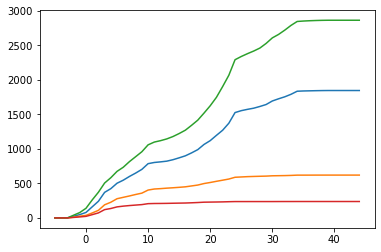

In [41]:
#import matplotlib.pyplot as plt
Y_PassEEE2014J= tbl_week_aggnostd_two_click6[(tbl_week_aggnostd_two_click6['_surrogate_key_two'].isin(['PassEEE2014J']))]
Y_FailEEE2014J= tbl_week_aggnostd_two_click6[(tbl_week_aggnostd_two_click6['_surrogate_key_two'].isin(['FailEEE2014J']))]
Y_DistinctionEEE2014J= tbl_week_aggnostd_two_click6[(tbl_week_aggnostd_two_click6['_surrogate_key_two'].isin(['DistinctionEEE2014J']))]
Y_WithdrawnEEE2014J= tbl_week_aggnostd_two_click6[(tbl_week_aggnostd_two_click6['_surrogate_key_two'].isin(['WithdrawnEEE2014J']))]

plt.plot(Y_PassEEE2014J['_date_group'], Y_PassEEE2014J['per_student_avg_week_agg_cum_sum_click'])
plt.plot(Y_FailEEE2014J['_date_group'], Y_FailEEE2014J['per_student_avg_week_agg_cum_sum_click'])
plt.plot(Y_DistinctionEEE2014J['_date_group'], Y_DistinctionEEE2014J['per_student_avg_week_agg_cum_sum_click'])
plt.plot(Y_WithdrawnEEE2014J['_date_group'], Y_WithdrawnEEE2014J['per_student_avg_week_agg_cum_sum_click'])
#plt.plot(_date_group, np.cos(x));

# STATS homoscedasticity VS heteroskedasticity 

##### SCORE

In [42]:
#X_PassEEE2014J.to_csv('X_PassEEE2014J.csv',index=True,header=True)
#X_FailEEE2014J.to_csv('X_FailEEE2014J.csv',index=True,header=True)
#X_DistinctionEEE2014J.to_csv('X_DistinctionEEE2014J.csv',index=True,header=True)
#X_WithdrawnEEE2014J.to_csv('X_WithdrawnEEE2014J.csv',index=True,header=True)

#Y_PassEEE2014J.to_csv('Y_PassEEE2014J.csv',index=True,header=True)
#Y_FailEEE2014J.to_csv('Y_FailEEE2014J.csv',index=True,header=True)
#Y_DistinctionEEE2014J.to_csv('Y_DistinctionEEE2014J.csv',index=True,header=True)
#Y_WithdrawnEEE2014J.to_csv('Y_WithdrawnEEE2014J.csv',index=True,header=True)

In [43]:
Z1_PassEEE2014J=X_PassEEE2014J[['_date_group','per_student_avg_week_agg_cum_weighted_score']]

In [44]:
Z1_PassEEE2014J

,_date_group,per_student_avg_week_agg_cum_weighted_score
5208,-3,0.000000
5209,-2,0.000000
5210,-1,0.000000
5211,0,0.391651
5212,1,0.391651
...,...,...
5296,85,79.243795
5297,86,79.243795
5298,87,79.243795
5299,88,79.243795


In [45]:
#import pandas as pd
#import numpy as np
#from matplotlib import pyplot as plt
#import statsmodels.api as sm
#import statsmodels.formula.api as smf
#from patsy import dmatrices
#from statsmodels.stats.diagnostic import het_white
#from statsmodels.compat import lzip

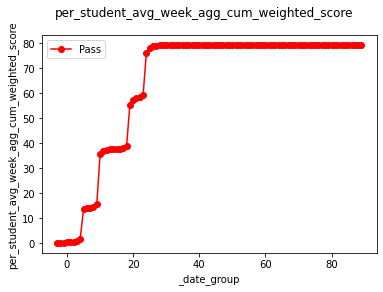

In [46]:
fig = plt.figure()
fig.suptitle('per_student_avg_week_agg_cum_weighted_score')
plt.xlabel('_date_group')
plt.ylabel('per_student_avg_week_agg_cum_weighted_score')
actual, = plt.plot(Z1_PassEEE2014J['_date_group'], Z1_PassEEE2014J['per_student_avg_week_agg_cum_weighted_score'], 'ro-', label='Pass')
plt.legend(handles=[actual])
plt.show()

In [47]:
expr = 'per_student_avg_week_agg_cum_weighted_score ~ _date_group'
olsr_results = smf.ols(expr, Z1_PassEEE2014J).fit()

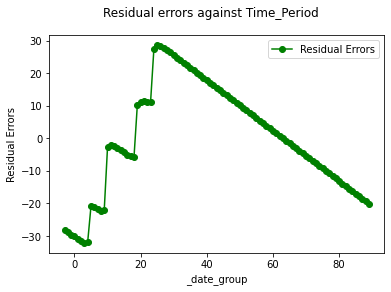

In [48]:
fig = plt.figure()
fig.suptitle('Residual errors against Time_Period')
plt.xlabel('_date_group')
plt.ylabel('Residual Errors')
actual, = plt.plot(Z1_PassEEE2014J['_date_group'], olsr_results.resid, 'go-', label='Residual Errors')
plt.legend(handles=[actual])
plt.show()

In [49]:
# Run the White test of heteroscedasticity on the residual errors

Z1_PassEEE2014J['SQ_RESID'] = np.power(olsr_results.resid, 2.0)
Z1_PassEEE2014J['SQ_date_group'] = np.power(Z1_PassEEE2014J['_date_group'], 2.0)

aux_expr = 'SQ_RESID ~ _date_group + SQ_date_group'
y, X = dmatrices(aux_expr, Z1_PassEEE2014J, return_type='dataframe')
X = sm.add_constant(X)
aux_olsr_results = sm.OLS(y, X).fit()
print(aux_olsr_results.summary())

                            OLS Regression Results                            
Dep. Variable:               SQ_RESID   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     25.81
Date:                Tue, 19 Oct 2021   Prob (F-statistic):           1.38e-09
Time:                        14:53:32   Log-Likelihood:                -639.82
No. Observations:                  93   AIC:                             1286.
Df Residuals:                      90   BIC:                             1293.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       688.0355     63.866     10.773

<ipython-input-49-4a6a2aea329e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z1_PassEEE2014J['SQ_RESID'] = np.power(olsr_results.resid, 2.0)
<ipython-input-49-4a6a2aea329e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z1_PassEEE2014J['SQ_date_group'] = np.power(Z1_PassEEE2014J['_date_group'], 2.0)


In [50]:
expr = 'per_student_avg_week_agg_cum_weighted_score ~ _date_group'
y, X = dmatrices(expr, Z1_PassEEE2014J, return_type='dataframe')
keys = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:', 'F-statistic:', 'F-test\'s p-value:']
results = het_white(olsr_results.resid, X)
lzip(keys, results)

[('Lagrange Multiplier statistic:', 33.89609764887461),
 ("LM test's p-value:", 4.360697054706808e-08),
 ('F-statistic:', 25.80750734761448),
 ("F-test's p-value:", 1.3835483660656288e-09)]

##### Significance of regression coefficients: 
* The p-value of _date_group and SQ_date_group are 0 (low), 
* causing us to reject the null hypothesis of the t-test 
* that both coefficients are significant 
* i.e. they are not zero.

* LM test: The LM test’s statistic follows the Chi-squared distribution with 
* degrees of freedom = DF of model minus one = (3–1) = 2. 
* It’s p-value (4.360697054706808e-08) is very low. 
* So we reject the null hypothesis of the test (that there is no heteroscedastisticity in the residual errors).
* In other words, heteroscedasticity exists    

* F-test: The F-test’s statistic follows the F-distribution. 
* Again, the low p-value of 1.3835483660656288e-09 
* rejects the null hypothesis of the test (that there is no heteroscedastisticity in the residual errors.)
* In other words, heteroscedasticity exists    

* aside from X_PassEEE2014J, the rest of the X_FailEEE2014J, X_DistinctionEEE2014J and X_WithdrawnEEE2014J 
* follows the same distributional trend and therefore we conclude that homoscedasticity criteria is NOT MET

* heteroscedastic - variance (y|X) increases with X
* homoscedastic - variance (y|X) is constant

##### CLICKS

In [51]:
Z2_PassEEE2014J=Y_PassEEE2014J[['_date_group','per_student_avg_week_agg_cum_sum_click']]

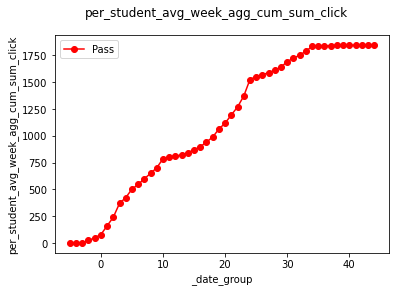

In [52]:
fig = plt.figure()
fig.suptitle('per_student_avg_week_agg_cum_sum_click')
plt.xlabel('_date_group')
plt.ylabel('per_student_avg_week_agg_cum_sum_click')
actual, = plt.plot(Z2_PassEEE2014J['_date_group'], Z2_PassEEE2014J['per_student_avg_week_agg_cum_sum_click'], 'ro-', label='Pass')
plt.legend(handles=[actual])
plt.show()

In [53]:
expr = 'per_student_avg_week_agg_cum_sum_click ~ _date_group'
olsr_results = smf.ols(expr, Z2_PassEEE2014J).fit()

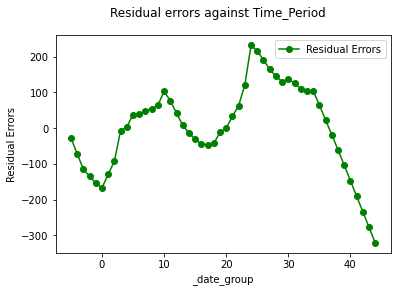

In [54]:
fig = plt.figure()
fig.suptitle('Residual errors against Time_Period')
plt.xlabel('_date_group')
plt.ylabel('Residual Errors')
actual, = plt.plot(Z2_PassEEE2014J['_date_group'], olsr_results.resid, 'go-', label='Residual Errors')
plt.legend(handles=[actual])
plt.show()

In [55]:
# Run the White test of heteroscedasticity on the residual errors

Z2_PassEEE2014J['SQ_RESID'] = np.power(olsr_results.resid, 2.0)
Z2_PassEEE2014J['SQ_date_group'] = np.power(Z2_PassEEE2014J['_date_group'], 2.0)

aux_expr = 'SQ_RESID ~ _date_group + SQ_date_group'
y, X = dmatrices(aux_expr, Z2_PassEEE2014J, return_type='dataframe')
X = sm.add_constant(X)
aux_olsr_results = sm.OLS(y, X).fit()
print(aux_olsr_results.summary())

                            OLS Regression Results                            
Dep. Variable:               SQ_RESID   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     13.09
Date:                Tue, 19 Oct 2021   Prob (F-statistic):           3.02e-05
Time:                        14:53:33   Log-Likelihood:                -557.11
No. Observations:                  50   AIC:                             1120.
Df Residuals:                      47   BIC:                             1126.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.026e+04   4672.835      2.196

<ipython-input-55-78936d57693c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z2_PassEEE2014J['SQ_RESID'] = np.power(olsr_results.resid, 2.0)
<ipython-input-55-78936d57693c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z2_PassEEE2014J['SQ_date_group'] = np.power(Z2_PassEEE2014J['_date_group'], 2.0)


In [56]:
expr = 'per_student_avg_week_agg_cum_sum_click ~ _date_group'
y, X = dmatrices(expr, Z2_PassEEE2014J, return_type='dataframe')
keys = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:', 'F-statistic:', 'F-test\'s p-value:']
results = het_white(olsr_results.resid, X)
lzip(keys, results)

[('Lagrange Multiplier statistic:', 17.889810232466214),
 ("LM test's p-value:", 0.00013039984250801042),
 ('F-statistic:', 13.092745433975226),
 ("F-test's p-value:", 3.022124801062823e-05)]

* For clicks... 
* The p-value of Time_Period are quite high, causing us to accept the null hypothesis of the t-test 
* that both coefficients are not significant i.e. they are basically zero.

* p-value is very high. So we accept the null hypothesis of the test 
* that there is no heteroscedastisticity in the residual errors.
* The F-test’s statistic follows the F-distribution. Again, the high p-value confirms the null hypothesis of the test 
* that there is no heteroscedastisticity in the residual errors.

For writeups, follow this to explain
https://www.statisticshowto.com/probability-and-statistics/f-statistic-value-test/

# Wilcoxon sum rank test

In [57]:
# splitting into relevant groups, parsing relevant columns into list

Z1B_PassEEE2014J = X_PassEEE2014J['per_student_avg_week_agg_cum_weighted_score'].tolist()
Z1B_FailEEE2014J = X_FailEEE2014J['per_student_avg_week_agg_cum_weighted_score'].tolist()
Z1B_DistinctionEEE2014J = X_DistinctionEEE2014J['per_student_avg_week_agg_cum_weighted_score'].tolist()
Z1B_WithdrawnEEE2014J = X_WithdrawnEEE2014J['per_student_avg_week_agg_cum_weighted_score'].tolist()

Z2B_PassEEE2014J = Y_PassEEE2014J['per_student_avg_week_agg_cum_sum_click'].tolist()
Z2B_FailEEE2014J = Y_FailEEE2014J['per_student_avg_week_agg_cum_sum_click'].tolist()
Z2B_DistinctionEEE2014J = Y_DistinctionEEE2014J['per_student_avg_week_agg_cum_sum_click'].tolist()
Z2B_WithdrawnEEE2014J = Y_WithdrawnEEE2014J['per_student_avg_week_agg_cum_sum_click'].tolist()

In [58]:
#import scipy.stats as stats
#perform the Wilcoxon-Signed Rank Test
#https://www.statology.org/wilcoxon-signed-rank-test-python/
print(stats.wilcoxon(Z1B_PassEEE2014J, Z1B_FailEEE2014J))
print(stats.wilcoxon(Z1B_PassEEE2014J, Z1B_DistinctionEEE2014J))
print(stats.wilcoxon(Z1B_FailEEE2014J, Z1B_DistinctionEEE2014J))

print(stats.wilcoxon(Z2B_PassEEE2014J, Z2B_FailEEE2014J))
print(stats.wilcoxon(Z2B_PassEEE2014J, Z2B_DistinctionEEE2014J))
print(stats.wilcoxon(Z2B_FailEEE2014J, Z2B_DistinctionEEE2014J))

WilcoxonResult(statistic=15.0, pvalue=1.7344987822256318e-17)
WilcoxonResult(statistic=6.0, pvalue=1.2521199150186698e-17)
WilcoxonResult(statistic=13.0, pvalue=1.1805690287184972e-17)
WilcoxonResult(statistic=0.0, pvalue=2.375445145319962e-09)
WilcoxonResult(statistic=0.0, pvalue=2.375445145319962e-09)
WilcoxonResult(statistic=0.0, pvalue=2.375445145319962e-09)


In [59]:
### filter by time period
### run again

In [60]:
Z1B0_PassEEE2014J = X_PassEEE2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_PassEEE2014J['_date_group'] >=-3) & (X_PassEEE2014J['_date_group'] <=4)]
Z1B1_PassEEE2014J = X_PassEEE2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_PassEEE2014J['_date_group'] >=5) & (X_PassEEE2014J['_date_group'] <=9)]
Z1B2_PassEEE2014J = X_PassEEE2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_PassEEE2014J['_date_group'] >=10) & (X_PassEEE2014J['_date_group'] <=18)]
Z1B3_PassEEE2014J = X_PassEEE2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_PassEEE2014J['_date_group'] >=19) & (X_PassEEE2014J['_date_group'] <=23)]
Z1B4_PassEEE2014J = X_PassEEE2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_PassEEE2014J['_date_group'] >=24)]

Z1B0_FailEEE2014J = X_FailEEE2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_FailEEE2014J['_date_group'] >=-3) & (X_FailEEE2014J['_date_group'] <=4)]
Z1B1_FailEEE2014J = X_FailEEE2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_FailEEE2014J['_date_group'] >=5) & (X_FailEEE2014J['_date_group'] <=9)]
Z1B2_FailEEE2014J = X_FailEEE2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_FailEEE2014J['_date_group'] >=10) & (X_FailEEE2014J['_date_group'] <=18)]
Z1B3_FailEEE2014J = X_FailEEE2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_FailEEE2014J['_date_group'] >=19) & (X_FailEEE2014J['_date_group'] <=23)]
Z1B4_FailEEE2014J = X_FailEEE2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_FailEEE2014J['_date_group'] >=24)]

Z1B0_DistinctionEEE2014J = X_DistinctionEEE2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_DistinctionEEE2014J['_date_group'] >=-3) & (X_DistinctionEEE2014J['_date_group'] <=4)]
Z1B1_DistinctionEEE2014J = X_DistinctionEEE2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_DistinctionEEE2014J['_date_group'] >=5) & (X_DistinctionEEE2014J['_date_group'] <=9)]
Z1B2_DistinctionEEE2014J = X_DistinctionEEE2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_DistinctionEEE2014J['_date_group'] >=10) & (X_DistinctionEEE2014J['_date_group'] <=18)]
Z1B3_DistinctionEEE2014J = X_DistinctionEEE2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_DistinctionEEE2014J['_date_group'] >=19) & (X_DistinctionEEE2014J['_date_group'] <=23)]
Z1B4_DistinctionEEE2014J = X_DistinctionEEE2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_DistinctionEEE2014J['_date_group'] >=24)]

In [61]:
print(stats.wilcoxon(Z1B0_PassEEE2014J, Z1B0_FailEEE2014J))
print(stats.wilcoxon(Z1B0_PassEEE2014J, Z1B0_DistinctionEEE2014J))
print(stats.wilcoxon(Z1B0_FailEEE2014J, Z1B0_DistinctionEEE2014J))

print(stats.wilcoxon(Z1B1_PassEEE2014J, Z1B1_FailEEE2014J))
print(stats.wilcoxon(Z1B1_PassEEE2014J, Z1B1_DistinctionEEE2014J))
print(stats.wilcoxon(Z1B1_FailEEE2014J, Z1B1_DistinctionEEE2014J))

print(stats.wilcoxon(Z1B2_PassEEE2014J, Z1B2_FailEEE2014J))
print(stats.wilcoxon(Z1B2_PassEEE2014J, Z1B2_DistinctionEEE2014J))
print(stats.wilcoxon(Z1B2_FailEEE2014J, Z1B2_DistinctionEEE2014J))

print(stats.wilcoxon(Z1B3_PassEEE2014J, Z1B3_FailEEE2014J))
print(stats.wilcoxon(Z1B3_PassEEE2014J, Z1B3_DistinctionEEE2014J))
print(stats.wilcoxon(Z1B3_FailEEE2014J, Z1B3_DistinctionEEE2014J))

print(stats.wilcoxon(Z1B4_PassEEE2014J, Z1B4_FailEEE2014J))
print(stats.wilcoxon(Z1B4_PassEEE2014J, Z1B4_DistinctionEEE2014J))
print(stats.wilcoxon(Z1B4_FailEEE2014J, Z1B4_DistinctionEEE2014J))

WilcoxonResult(statistic=0.0, pvalue=0.04216819709715596)
WilcoxonResult(statistic=6.0, pvalue=0.6844698210251553)
WilcoxonResult(statistic=2.0, pvalue=0.13621686984456766)
WilcoxonResult(statistic=0.0, pvalue=0.0625)
WilcoxonResult(statistic=0.0, pvalue=0.0625)
WilcoxonResult(statistic=0.0, pvalue=0.0625)
WilcoxonResult(statistic=0.0, pvalue=0.00390625)
WilcoxonResult(statistic=0.0, pvalue=0.00390625)
WilcoxonResult(statistic=0.0, pvalue=0.00390625)
WilcoxonResult(statistic=0.0, pvalue=0.0625)
WilcoxonResult(statistic=0.0, pvalue=0.0625)
WilcoxonResult(statistic=0.0, pvalue=0.0625)
WilcoxonResult(statistic=0.0, pvalue=3.814915564039236e-15)
WilcoxonResult(statistic=0.0, pvalue=3.814915564039236e-15)
WilcoxonResult(statistic=0.0, pvalue=1.7465864069778473e-15)


C:\Users\EeLian\anaconda3\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\EeLian\anaconda3\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Significance is noted by second phase of assessment submissions ...

* Since the p-value is less than 0.05, we reject the null hypothesis. 
* We have sufficient evidence to say that the true mean is not equal between the two groups.
* and the earliest phase for p value is at phase 2, from week 10 onwards

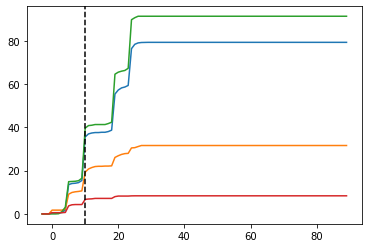

In [62]:
plt.plot(X_PassEEE2014J['_date_group'], X_PassEEE2014J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_FailEEE2014J['_date_group'], X_FailEEE2014J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_DistinctionEEE2014J['_date_group'], X_DistinctionEEE2014J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_WithdrawnEEE2014J['_date_group'], X_WithdrawnEEE2014J['per_student_avg_week_agg_cum_weighted_score'])
plt.axvline(x=10, color='k', linestyle='--')

* Week 10 (till 18) is the first point of significance
* select Week 16 when most of the assessment submissions has completed

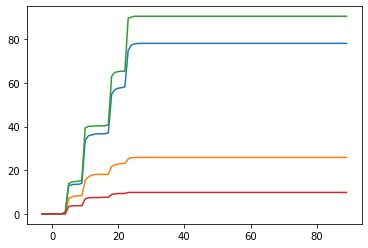

In [63]:
X_PassEEE2013J= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['PassEEE2013J']))]
X_FailEEE2013J= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['FailEEE2013J']))]
X_DistinctionEEE2013J= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['DistinctionEEE2013J']))]
X_WithdrawnEEE2013J= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['WithdrawnEEE2013J']))]

plt.plot(X_PassEEE2013J['_date_group'], X_PassEEE2013J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_FailEEE2013J['_date_group'], X_FailEEE2013J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_DistinctionEEE2013J['_date_group'], X_DistinctionEEE2013J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_WithdrawnEEE2013J['_date_group'], X_WithdrawnEEE2013J['per_student_avg_week_agg_cum_weighted_score'])
#plt.plot(_date_group, np.cos(x));

##### What about the Rest?

* CCC, DDD, EEE, FFF are STEM
* AAA, BBB, GGG are social sciences

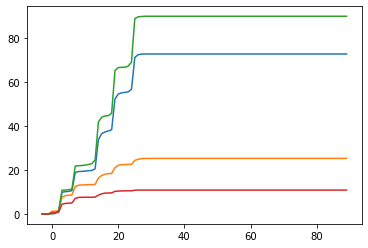

In [64]:
X_PassFFF2013J= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['PassFFF2013J']))]
X_FailFFF2013J= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['FailFFF2013J']))]
X_DistinctionFFF2013J= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['DistinctionFFF2013J']))]
X_WithdrawnFFF2013J= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['WithdrawnFFF2013J']))]

plt.plot(X_PassFFF2013J['_date_group'], X_PassFFF2013J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_FailFFF2013J['_date_group'], X_FailFFF2013J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_DistinctionFFF2013J['_date_group'], X_DistinctionFFF2013J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_WithdrawnFFF2013J['_date_group'], X_WithdrawnFFF2013J['per_student_avg_week_agg_cum_weighted_score'])
#plt.plot(_date_group, np.cos(x));

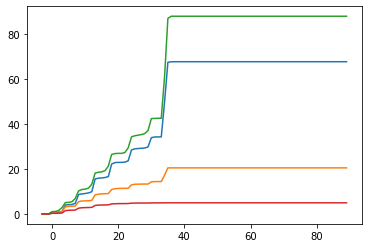

In [65]:
X_PassDDD2013J= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['PassDDD2013J']))]
X_FailDDD2013J= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['FailDDD2013J']))]
X_DistinctionDDD2013J= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['DistinctionDDD2013J']))]
X_WithdrawnDDD2013J= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['WithdrawnDDD2013J']))]

plt.plot(X_PassDDD2013J['_date_group'], X_PassDDD2013J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_FailDDD2013J['_date_group'], X_FailDDD2013J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_DistinctionDDD2013J['_date_group'], X_DistinctionDDD2013J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_WithdrawnDDD2013J['_date_group'], X_WithdrawnDDD2013J['per_student_avg_week_agg_cum_weighted_score'])
#plt.plot(_date_group, np.cos(x));

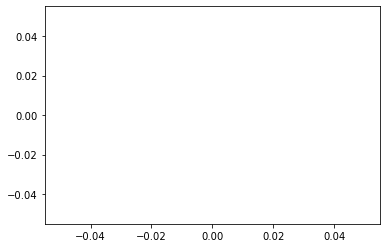

In [66]:
X_PassEEE2013B= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['PassEEE2013B']))]
X_FailEEE2013B= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['FailEEE2013B']))]
X_DistinctionEEE2013B= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['DistinctionEEE2013B']))]
X_WithdrawnEEE2013B= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['WithdrawnEEE2013B']))]

plt.plot(X_PassEEE2013B['_date_group'], X_PassEEE2013B['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_FailEEE2013B['_date_group'], X_FailEEE2013B['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_DistinctionEEE2013B['_date_group'], X_DistinctionEEE2013B['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_WithdrawnEEE2013B['_date_group'], X_WithdrawnEEE2013B['per_student_avg_week_agg_cum_weighted_score'])
#plt.plot(_date_group, np.cos(x));

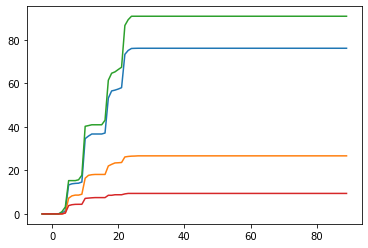

In [67]:
X_PassEEE2014B= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['PassEEE2014B']))]
X_FailEEE2014B= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['FailEEE2014B']))]
X_DistinctionEEE2014B= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['DistinctionEEE2014B']))]
X_WithdrawnEEE2014B= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['WithdrawnEEE2014B']))]

plt.plot(X_PassEEE2014B['_date_group'], X_PassEEE2014B['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_FailEEE2014B['_date_group'], X_FailEEE2014B['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_DistinctionEEE2014B['_date_group'], X_DistinctionEEE2014B['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_WithdrawnEEE2014B['_date_group'], X_WithdrawnEEE2014B['per_student_avg_week_agg_cum_weighted_score'])
#plt.plot(_date_group, np.cos(x));

There are more assessments steps during the longer J semesters for other STEM courses such as CCC, DDD, EEE, and FFF

Let's try to opt for the following at Week 16 cutoff point for modeling point
* EEE	2013J	1052 students for train week 
* EEE	2014B	 694 students for train week
* EEE	2014J	1188 students for test week 

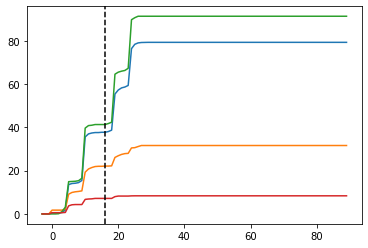

In [68]:
plt.plot(X_PassEEE2014J['_date_group'], X_PassEEE2014J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_FailEEE2014J['_date_group'], X_FailEEE2014J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_DistinctionEEE2014J['_date_group'], X_DistinctionEEE2014J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_WithdrawnEEE2014J['_date_group'], X_WithdrawnEEE2014J['per_student_avg_week_agg_cum_weighted_score'])
plt.axvline(x=16, color='k', linestyle='--')

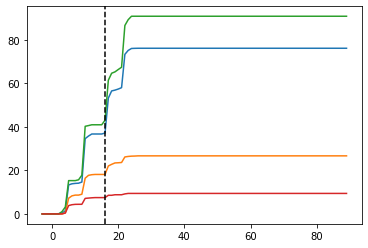

In [69]:
plt.plot(X_PassEEE2014B['_date_group'], X_PassEEE2014B['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_FailEEE2014B['_date_group'], X_FailEEE2014B['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_DistinctionEEE2014B['_date_group'], X_DistinctionEEE2014B['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_WithdrawnEEE2014B['_date_group'], X_WithdrawnEEE2014B['per_student_avg_week_agg_cum_weighted_score'])
plt.axvline(x=16, color='k', linestyle='--')

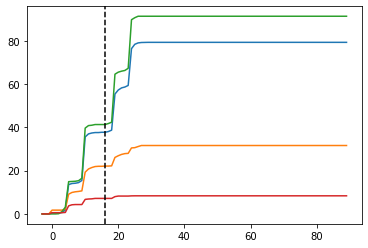

In [70]:
plt.plot(X_PassEEE2014J['_date_group'], X_PassEEE2014J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_FailEEE2014J['_date_group'], X_FailEEE2014J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_DistinctionEEE2014J['_date_group'], X_DistinctionEEE2014J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_WithdrawnEEE2014J['_date_group'], X_WithdrawnEEE2014J['per_student_avg_week_agg_cum_weighted_score'])
plt.axvline(x=16, color='k', linestyle='--')

### Control Group: FFF

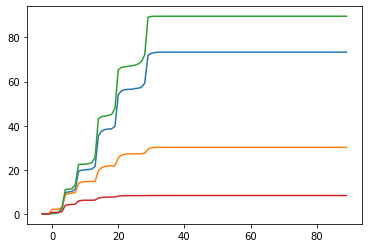

In [71]:
X_PassFFF2014J= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['PassFFF2014J']))]
X_FailFFF2014J= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['FailFFF2014J']))]
X_DistinctionFFF2014J= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['DistinctionFFF2014J']))]
X_WithdrawnFFF2014J= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['WithdrawnFFF2014J']))]

plt.plot(X_PassFFF2014J['_date_group'], X_PassFFF2014J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_FailFFF2014J['_date_group'], X_FailFFF2014J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_DistinctionFFF2014J['_date_group'], X_DistinctionFFF2014J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_WithdrawnFFF2014J['_date_group'], X_WithdrawnFFF2014J['per_student_avg_week_agg_cum_weighted_score'])

#X_PassFFF2014J.to_csv('X_PassFFF2014J.csv',index=True,header=True)
#X_FailFFF2014J.to_csv('X_FailFFF2014J.csv',index=True,header=True)
#X_DistinctionFFF2014J.to_csv('X_DistinctionFFF2014J.csv',index=True,header=True)
#X_WithdrawnFFF2014J.to_csv('X_WithdrawnFFF2014J.csv',index=True,header=True)

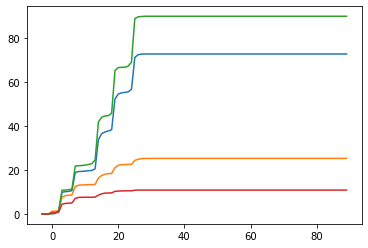

In [72]:
X_PassFFF2013J= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['PassFFF2013J']))]
X_FailFFF2013J= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['FailFFF2013J']))]
X_DistinctionFFF2013J= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['DistinctionFFF2013J']))]
X_WithdrawnFFF2013J= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['WithdrawnFFF2013J']))]

plt.plot(X_PassFFF2013J['_date_group'], X_PassFFF2013J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_FailFFF2013J['_date_group'], X_FailFFF2013J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_DistinctionFFF2013J['_date_group'], X_DistinctionFFF2013J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_WithdrawnFFF2013J['_date_group'], X_WithdrawnFFF2013J['per_student_avg_week_agg_cum_weighted_score'])

#X_PassFFF2013J.to_csv('X_PassFFF2013J.csv',index=True,header=True)
#X_FailFFF2013J.to_csv('X_FailFFF2013J.csv',index=True,header=True)
#X_DistinctionFFF2013J.to_csv('X_DistinctionFFF2013J.csv',index=True,header=True)
#X_WithdrawnFFF2013J.to_csv('X_WithdrawnFFF2013J.csv',index=True,header=True)

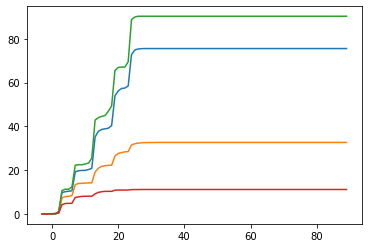

In [73]:
X_PassFFF2013B= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['PassFFF2013B']))]
X_FailFFF2013B= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['FailFFF2013B']))]
X_DistinctionFFF2013B= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['DistinctionFFF2013B']))]
X_WithdrawnFFF2013B= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['WithdrawnFFF2013B']))]

plt.plot(X_PassFFF2013B['_date_group'], X_PassFFF2013B['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_FailFFF2013B['_date_group'], X_FailFFF2013B['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_DistinctionFFF2013B['_date_group'], X_DistinctionFFF2013B['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_WithdrawnFFF2013B['_date_group'], X_WithdrawnFFF2013B['per_student_avg_week_agg_cum_weighted_score'])

#X_PassFFF2013B.to_csv('X_PassFFF2013B.csv',index=True,header=True)
#X_FailFFF2013B.to_csv('X_FailFFF2013B.csv',index=True,header=True)
#X_DistinctionFFF2013B.to_csv('X_DistinctionFFF2013B.csv',index=True,header=True)
#X_WithdrawnFFF2013B.to_csv('X_WithdrawnFFF2013B.csv',index=True,header=True)

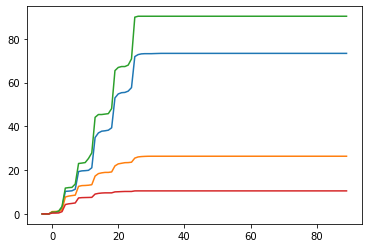

In [74]:
X_PassFFF2014B= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['PassFFF2014B']))]
X_FailFFF2014B= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['FailFFF2014B']))]
X_DistinctionFFF2014B= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['DistinctionFFF2014B']))]
X_WithdrawnFFF2014B= tbl_week_aggnostd_two_score6[(tbl_week_aggnostd_two_score6['_surrogate_key_two'].isin(['WithdrawnFFF2014B']))]

plt.plot(X_PassFFF2014B['_date_group'], X_PassFFF2014B['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_FailFFF2014B['_date_group'], X_FailFFF2014B['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_DistinctionFFF2014B['_date_group'], X_DistinctionFFF2014B['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_WithdrawnFFF2014B['_date_group'], X_WithdrawnFFF2014B['per_student_avg_week_agg_cum_weighted_score'])

#X_PassFFF2014B.to_csv('X_PassFFF2014B.csv',index=True,header=True)
#X_FailFFF2014B.to_csv('X_FailFFF2014B.csv',index=True,header=True)
#X_DistinctionFFF2014B.to_csv('X_DistinctionFFF2014B.csv',index=True,header=True)
#X_WithdrawnFFF2014B.to_csv('X_WithdrawnFFF2014B.csv',index=True,header=True)

In [75]:
Z1B_PassFFF2014J = X_PassFFF2014J['per_student_avg_week_agg_cum_weighted_score'].tolist()
Z1B_FailFFF2014J = X_FailFFF2014J['per_student_avg_week_agg_cum_weighted_score'].tolist()
Z1B_DistinctionFFF2014J = X_DistinctionFFF2014J['per_student_avg_week_agg_cum_weighted_score'].tolist()
Z1B_WithdrawnFFFF2014J = X_WithdrawnFFF2014J['per_student_avg_week_agg_cum_weighted_score'].tolist()

#Z2B_PassFFF2014J = Y_PassFFF2014J['per_student_avg_week_agg_cum_sum_click'].tolist()
#Z2B_FailFFF2014J = Y_FailFFF2014J['per_student_avg_week_agg_cum_sum_click'].tolist()
#Z2B_DistinctionFFF2014J = Y_DistinctionFFF2014J['per_student_avg_week_agg_cum_sum_click'].tolist()
#Z2B_WithdrawnFFF2014J = Y_WithdrawnFFF2014J['per_student_avg_week_agg_cum_sum_click'].tolist()

print('FFF2014J')
print(stats.wilcoxon(Z1B_PassFFF2014J, Z1B_FailFFF2014J))
print(stats.wilcoxon(Z1B_PassFFF2014J, Z1B_DistinctionFFF2014J))
print(stats.wilcoxon(Z1B_FailFFF2014J, Z1B_DistinctionFFF2014J))

#print(stats.wilcoxon(Z2B_PassFFF2014J, Z2B_FailFFF2014J))
#print(stats.wilcoxon(Z2B_PassFFF2014J, Z2B_DistinctionFFF2014J))
#print(stats.wilcoxon(Z2B_FailFFF2014J, Z2B_DistinctionFFF2014J))


Z1B0_PassFFF2014J = X_PassFFF2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_PassFFF2014J['_date_group'] >=0) & (X_PassFFF2014J['_date_group'] <=3)]
Z1B1_PassFFF2014J = X_PassFFF2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_PassFFF2014J['_date_group'] >=4) & (X_PassFFF2014J['_date_group'] <=7)]
Z1B2_PassFFF2014J = X_PassFFF2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_PassFFF2014J['_date_group'] >=8) & (X_PassFFF2014J['_date_group'] <=13)]
Z1B3_PassFFF2014J = X_PassFFF2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_PassFFF2014J['_date_group'] >=14) & (X_PassFFF2014J['_date_group'] <=19)]
Z1B4_PassFFF2014J = X_PassFFF2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_PassFFF2014J['_date_group'] >=20) & (X_PassFFF2014J['_date_group'] <=28)]
Z1B5_PassFFF2014J = X_PassFFF2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_PassFFF2014J['_date_group'] >=29)]

Z1B0_FailFFF2014J = X_FailFFF2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_FailFFF2014J['_date_group'] >=0) & (X_FailFFF2014J['_date_group'] <=3)]
Z1B1_FailFFF2014J = X_FailFFF2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_FailFFF2014J['_date_group'] >=4) & (X_FailFFF2014J['_date_group'] <=7)]
Z1B2_FailFFF2014J = X_FailFFF2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_FailFFF2014J['_date_group'] >=8) & (X_FailFFF2014J['_date_group'] <=13)]
Z1B3_FailFFF2014J = X_FailFFF2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_FailFFF2014J['_date_group'] >=14) & (X_FailFFF2014J['_date_group'] <=19)]
Z1B4_FailFFF2014J = X_FailFFF2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_FailFFF2014J['_date_group'] >=20) & (X_FailFFF2014J['_date_group'] <=28)]
Z1B5_FailFFF2014J = X_FailFFF2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_FailFFF2014J['_date_group'] >=29)]

Z1B0_DistinctionFFF2014J = X_DistinctionFFF2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_DistinctionFFF2014J['_date_group'] >=0) & (X_DistinctionFFF2014J['_date_group'] <=3)]
Z1B1_DistinctionFFF2014J = X_DistinctionFFF2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_DistinctionFFF2014J['_date_group'] >=4) & (X_DistinctionFFF2014J['_date_group'] <=7)]
Z1B2_DistinctionFFF2014J = X_DistinctionFFF2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_DistinctionFFF2014J['_date_group'] >=8) & (X_DistinctionFFF2014J['_date_group'] <=13)]
Z1B3_DistinctionFFF2014J = X_DistinctionFFF2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_DistinctionFFF2014J['_date_group'] >=14) & (X_DistinctionFFF2014J['_date_group'] <=19)]
Z1B4_DistinctionFFF2014J = X_DistinctionFFF2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_DistinctionFFF2014J['_date_group'] >=20) & (X_DistinctionFFF2014J['_date_group'] <=28)]
Z1B5_DistinctionFFF2014J = X_DistinctionFFF2014J['per_student_avg_week_agg_cum_weighted_score'][\
    (X_DistinctionFFF2014J['_date_group'] >=29)]



print('FFF2014J Breakdown')
print(stats.wilcoxon(Z1B0_PassFFF2014J, Z1B0_FailFFF2014J))
print(stats.wilcoxon(Z1B0_PassFFF2014J, Z1B0_DistinctionFFF2014J))
print(stats.wilcoxon(Z1B0_FailFFF2014J, Z1B0_DistinctionFFF2014J))

print(stats.wilcoxon(Z1B1_PassFFF2014J, Z1B1_FailFFF2014J))
print(stats.wilcoxon(Z1B1_PassFFF2014J, Z1B1_DistinctionFFF2014J))
print(stats.wilcoxon(Z1B1_FailFFF2014J, Z1B1_DistinctionFFF2014J))

print(stats.wilcoxon(Z1B2_PassFFF2014J, Z1B2_FailFFF2014J))
print(stats.wilcoxon(Z1B2_PassFFF2014J, Z1B2_DistinctionFFF2014J))
print(stats.wilcoxon(Z1B2_FailFFF2014J, Z1B2_DistinctionFFF2014J))

print(stats.wilcoxon(Z1B3_PassFFF2014J, Z1B3_FailFFF2014J))
print(stats.wilcoxon(Z1B3_PassFFF2014J, Z1B3_DistinctionFFF2014J))
print(stats.wilcoxon(Z1B3_FailFFF2014J, Z1B3_DistinctionFFF2014J))

print(stats.wilcoxon(Z1B4_PassFFF2014J, Z1B4_FailFFF2014J))
print(stats.wilcoxon(Z1B4_PassFFF2014J, Z1B4_DistinctionFFF2014J))
print(stats.wilcoxon(Z1B4_FailFFF2014J, Z1B4_DistinctionFFF2014J))

print(stats.wilcoxon(Z1B5_PassFFF2014J, Z1B5_FailFFF2014J))
print(stats.wilcoxon(Z1B5_PassFFF2014J, Z1B5_DistinctionFFF2014J))
print(stats.wilcoxon(Z1B5_FailFFF2014J, Z1B5_DistinctionFFF2014J))

FFF2014J
WilcoxonResult(statistic=22.0, pvalue=3.395891295111938e-17)
WilcoxonResult(statistic=6.0, pvalue=1.91754781143397e-17)
WilcoxonResult(statistic=10.0, pvalue=2.2129744604316323e-17)
FFF2014J Breakdown
WilcoxonResult(statistic=0.0, pvalue=0.125)
WilcoxonResult(statistic=4.0, pvalue=0.875)
WilcoxonResult(statistic=0.0, pvalue=0.125)
WilcoxonResult(statistic=0.0, pvalue=0.125)
WilcoxonResult(statistic=0.0, pvalue=0.125)
WilcoxonResult(statistic=0.0, pvalue=0.125)
WilcoxonResult(statistic=0.0, pvalue=0.03125)
WilcoxonResult(statistic=0.0, pvalue=0.03125)
WilcoxonResult(statistic=0.0, pvalue=0.03125)
WilcoxonResult(statistic=0.0, pvalue=0.03125)
WilcoxonResult(statistic=0.0, pvalue=0.03125)
WilcoxonResult(statistic=0.0, pvalue=0.03125)
WilcoxonResult(statistic=0.0, pvalue=0.00390625)
WilcoxonResult(statistic=0.0, pvalue=0.00390625)
WilcoxonResult(statistic=0.0, pvalue=0.00390625)
WilcoxonResult(statistic=0.0, pvalue=2.1867492103603084e-14)
WilcoxonResult(statistic=0.0, pvalue=2.186

In [76]:
# Between Week 8 and 13 for FFF2014J for pvalue<0.05

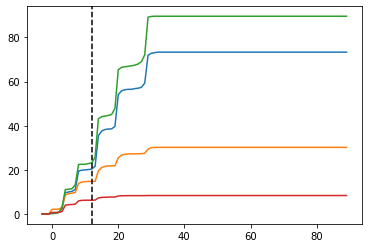

In [77]:
plt.plot(X_PassFFF2014J['_date_group'], X_PassFFF2014J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_FailFFF2014J['_date_group'], X_FailFFF2014J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_DistinctionFFF2014J['_date_group'], X_DistinctionFFF2014J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_WithdrawnFFF2014J['_date_group'], X_WithdrawnFFF2014J['per_student_avg_week_agg_cum_weighted_score'])
plt.axvline(x=12, color='k', linestyle='--')

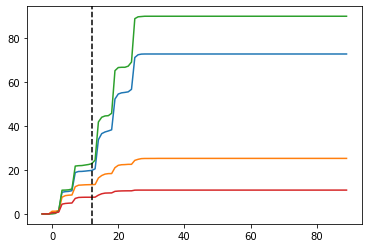

In [78]:
plt.plot(X_PassFFF2013J['_date_group'], X_PassFFF2013J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_FailFFF2013J['_date_group'], X_FailFFF2013J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_DistinctionFFF2013J['_date_group'], X_DistinctionFFF2013J['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_WithdrawnFFF2013J['_date_group'], X_WithdrawnFFF2013J['per_student_avg_week_agg_cum_weighted_score'])
plt.axvline(x=12, color='k', linestyle='--')

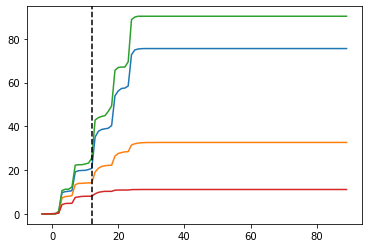

In [79]:
plt.plot(X_PassFFF2013B['_date_group'], X_PassFFF2013B['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_FailFFF2013B['_date_group'], X_FailFFF2013B['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_DistinctionFFF2013B['_date_group'], X_DistinctionFFF2013B['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_WithdrawnFFF2013B['_date_group'], X_WithdrawnFFF2013B['per_student_avg_week_agg_cum_weighted_score'])
plt.axvline(x=12, color='k', linestyle='--')

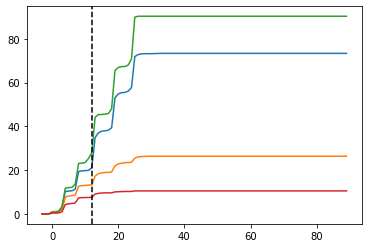

In [80]:
plt.plot(X_PassFFF2014B['_date_group'], X_PassFFF2014B['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_FailFFF2014B['_date_group'], X_FailFFF2014B['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_DistinctionFFF2014B['_date_group'], X_DistinctionFFF2014B['per_student_avg_week_agg_cum_weighted_score'])
plt.plot(X_WithdrawnFFF2014B['_date_group'], X_WithdrawnFFF2014B['per_student_avg_week_agg_cum_weighted_score'])
plt.axvline(x=12, color='k', linestyle='--')

Let's try to opt for the following at Week 12 cutoff point for modeling point
FFF 2013B 1614 students for train week
FFF 2013J 2283 students for train week
FFF 2014B 1500 students for train week
FFF 2014J 2365 students for test week